<a href="https://colab.research.google.com/github/Vey27/DeepLearning/blob/main/CNNmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install 

In [ ]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.51.1
    Uninstalling grpcio-1.51.1:
      Successfully uninstalled grpcio-1.51.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.24.3 which is incompatible.
google-cloud-bigquery 3.4.2 requires grpcio<2.0dev,>=1.47.0, but you have grpcio 1.24.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if not tf.__version__ == '2.2.0':
    printmd('<<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.2.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>>')

# <span style="color:red"><<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.2.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>></span>

### Downloading dataset mnist

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
print(y_train[0:5])

[5 0 4 1 9]


In [ ]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [ ]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

### Flatten

In [ ]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


### Weight tensor

In [ ]:

W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

In [ ]:
def forward(x):
    return tf.matmul(x,W) + b

### softmax calculation

In [ ]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [ ]:
def activate(x):
    return tf.nn.softmax(forward(x))

In [ ]:
def model(x):
    x = flatten(x)
    return activate(x)

Cost function


In [ ]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.12

### Type of optimization: Gradient Descent


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [ ]:
def train_step(x, y ):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

### Training batches


In [ ]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 


epoch  0 batch 500 loss: 308.78094
epoch  0 batch 1000 loss: 243.85347
end of epoch  0 loss 335063.8 accuracy 0.73728335
epoch  1 batch 500 loss: 270.43488
epoch  1 batch 1000 loss: 239.25098
end of epoch  1 loss 331978.1 accuracy 0.74156666
epoch  2 batch 500 loss: 290.95187
epoch  2 batch 1000 loss: 253.18973
end of epoch  2 loss 325348.25 accuracy 0.7507667
epoch  3 batch 500 loss: 292.71637
epoch  3 batch 1000 loss: 260.54138
end of epoch  3 loss 321318.7 accuracy 0.75453335
epoch  4 batch 500 loss: 289.2487
epoch  4 batch 1000 loss: 242.80728
end of epoch  4 loss 326882.06 accuracy 0.7500833
epoch  5 batch 500 loss: 280.16818
epoch  5 batch 1000 loss: 230.50214
end of epoch  5 loss 321615.75 accuracy 0.75516665
epoch  6 batch 500 loss: 277.45898
epoch  6 batch 1000 loss: 230.25873
end of epoch  6 loss 318383.2 accuracy 0.7596667
epoch  7 batch 500 loss: 296.34238
epoch  7 batch 1000 loss: 230.25853
end of epoch  7 loss 317834.22 accuracy 0.7604667
epoch  8 batch 500 loss: 294.9890

### Test and Plots

In [ ]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.7582833
test accuracy 0.7536


### The next two plots show the performance of the optimization at each epoch.


Text(0, 0.5, 'loss')

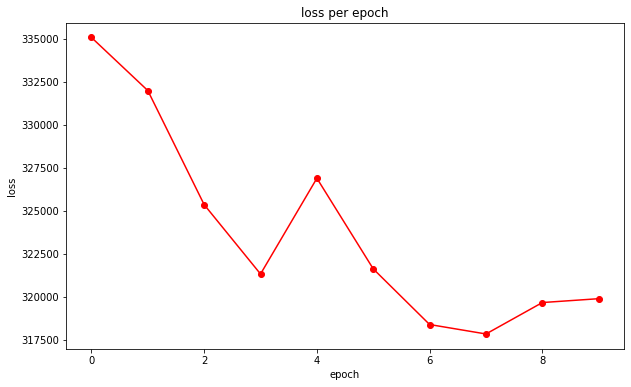

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

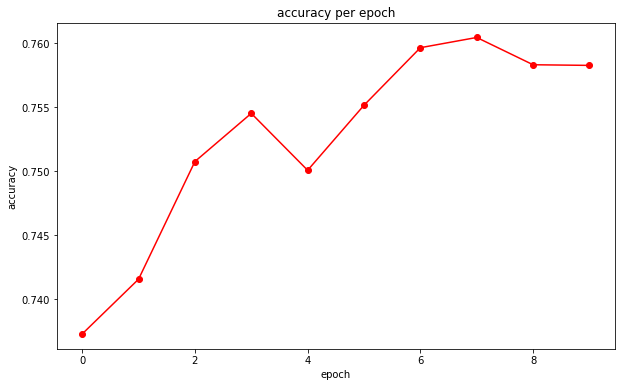

In [ ]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

### Evaluating the final result
84% accuracy is not bad considering the simplicity of the model, but >90% accuracy has been achieved in the past.  


# The MNIST data

### Initial parameters

In [ ]:
#Create general parameters for the model
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

### Converting images of the data set to tensors


In [ ]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [ ]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

In [ ]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [ ]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [ ]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)